# Loss vs Wavelength in Glass Tube

This uses the 3 layer exact RadialStep class and 2 layer StepExact class

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from step_exact import RadialStep
from scipy.optimize import newton

# Initialize

In [8]:
n = 300
wls = np.linspace(1.4e-6, 2e-6, n+1)
betas = np.zeros_like(wls, dtype=complex)
outer = 'h2'
nu = 1

# Three Layer Study: Air Outside Cladding

In [9]:
for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
          
    A = RadialStep(r1=15*2.7183333333333333e-6, t1=15*2/3*1e-6, t2=15*.4e-6, 
                   scale=15e-6, R1_maxh=5, R2_maxh=5, R3_maxh=5, wavelength=wl)

    k_low = A.k1 * A.scale
    guess = np.array(.99999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(A.hybrid_det_matrix, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.9999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.hybrid_det_matrix(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .99999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betas[i] = beta
    

     --------------------  1/301: wavelength: 1.4e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (67.33279925360031-4.654441237151492e-06j) . Residual of determinant:  6.158614761267611e-11 


     --------------------  2/301: wavelength: 1.4019999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (67.23671719706587-4.062535725874254e-06j) . Residual of determinant:  2.4706936263560762e-11 


     --------------------  3/301: wavelength: 1.404e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
Scaled beta:  (67.14091044873568-3.6092727709199053e-06j) . Residual of determinant:  7.28398638734256e-11 


     --------------------  4/301: wavelength: 1.406e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (67.04537746382402-3.256922922134148e-06j) . Residual of determinant: 

scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (64.56492686794157-9.634368888034368e-06j) . Residual of determinant:  1.3176259892012139e-11 


     --------------------  32/301: wavelength: 1.462e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
Scaled beta:  (64.47655689925978-1.2206689027550527e-05j) . Residual of determinant:  1.7580411956615228e-11 


     --------------------  33/301: wavelength: 1.4639999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
Scaled beta:  (64.38842021954964-1.606387707108152e-05j) . Residual of determinant:  6.756338323502114e-12 


     --------------------  34/301: wavelength: 1.466e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
Scaled beta:  (64.30051159407347-2.2210830328384634e-05j) . Residual of dete

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (62.75946870943139-5.598723225234297e-06j) . Residual of determinant:  2.90813198475158e-11 


     --------------------  53/301: wavelength: 1.504e-06  --------------------     

Scaled beta:  (62.67598263744959-4.985084102888649e-06j) . Residual of determinant:  4.997420973310347e-13 


     --------------------  54/301: wavelength: 1.5059999999999999e-06  --------------------     

Scaled beta:  (62.59271964859449-4.498132908511629e-06j) . Residual of determinant:  2.6711650122992913e-12 


     --------------------  55/301: wavelength: 1.508e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (62.50967857527058-4.107294010527896e-06j) . Residual of determinant:  1.8522837363449823e-11 


     --------------------  56/301: wavelength: 1.51e-06  --------------------     

Scaled beta:  (62.42685832215871-3.790959311578728e-06j) . Residual of 

scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
Scaled beta:  (60.11697956484443-9.34455006185444e-06j) . Residual of determinant:  1.436335265782551e-11 


     --------------------  86/301: wavelength: 1.57e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
Scaled beta:  (60.04035847399025-1.1095621688847717e-05j) . Residual of determinant:  1.666026658147738e-11 


     --------------------  87/301: wavelength: 1.572e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
Scaled beta:  (59.9639280623374-1.3452361331681517e-05j) . Residual of determinant:  1.464946403135442e-12 


     --------------------  88/301: wavelength: 1.5739999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
Scaled beta:  (59.887686092414754-1.6723151555727372e-05j) . Re

Scaled beta:  (58.04380692916122-5.689777018050428e-06j) . Residual of determinant:  2.6210974169883746e-11 


     --------------------  114/301: wavelength: 1.626e-06  --------------------     

Scaled beta:  (57.97238534543821-5.255530890393854e-06j) . Residual of determinant:  4.227430322353084e-12 


     --------------------  115/301: wavelength: 1.628e-06  --------------------     

Scaled beta:  (57.90114000301426-4.894045794041683e-06j) . Residual of determinant:  1.7939926809520302e-12 


     --------------------  116/301: wavelength: 1.6299999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
Scaled beta:  (57.83007012146869-4.591738657214384e-06j) . Residual of determinant:  5.85148330980038e-11 


     --------------------  117/301: wavelength: 1.6319999999999998e-06  --------------------     

Scaled beta:  (57.759174948403874-4.338249331082693e-06j) . Residual of determinant:  3

scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
Scaled beta:  (55.64444337725746-1.0006120122188577e-05j) . Residual of determinant:  1.3597687517714504e-11 


     --------------------  149/301: wavelength: 1.696e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
scaling guess: 8
scaling guess: 9
scaling guess: 10
Scaled beta:  (55.57878963893192-1.1389477867186826e-05j) . Residual of determinant:  4.77377857578771e-12 


     --------------------  150/301: wavelength: 1.6979999999999999e-06  --------------------     

Scaled beta:  (55.51328795266868-1.312606088810808e-05j) . Residual of determinant:  4.249322433596957e-12 


     --------------------  151/301: wavelength: 1.6999999999999998e-06  --------------------     

Scaled beta:  (55.44793711650212-1.5343515969487227e-05j) . Residual of determinant:  2.335422448112488e-12 




Scaled beta:  (54.17356120305653-2.935191280578876e-05j) . Residual of determinant:  7.764036921741032e-12 


     --------------------  172/301: wavelength: 1.742e-06  --------------------     

Scaled beta:  (54.11130554603604-2.4001408354101082e-05j) . Residual of determinant:  3.4621490471855293e-12 


     --------------------  173/301: wavelength: 1.744e-06  --------------------     

Scaled beta:  (54.049200176601786-2.0073908057087615e-05j) . Residual of determinant:  1.065774229768235e-11 


     --------------------  174/301: wavelength: 1.7459999999999999e-06  --------------------     

Scaled beta:  (53.98724262885711-1.7107441965928018e-05j) . Residual of determinant:  3.37196475533161e-12 


     --------------------  175/301: wavelength: 1.7479999999999998e-06  --------------------     

Scaled beta:  (53.925431063831425-1.4813467321532195e-05j) . Residual of determinant:  3.878506201630761e-12 


     --------------------  176/301: wavelength: 1.7499999999999998e-06  --

scaling guess: 1
Scaled beta:  (51.96259818765151-4.936631413336723e-06j) . Residual of determinant:  1.5848065096394743e-11 


     --------------------  209/301: wavelength: 1.8159999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
Scaled beta:  (51.905346881478195-5.095001714577553e-06j) . Residual of determinant:  1.5175116485793384e-11 


     --------------------  210/301: wavelength: 1.8179999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
Scaled beta:  (51.84822128230794-5.276793457620967e-06j) . Residual of determinant:  3.356915815023466e-11 


     --------------------  211/301: wavelength: 1.82e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
Scaled bet

scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
Captured wrong mode, retrying.
scaling guess: 8
Scaled beta:  (50.567845269966256-5.9431425210453735e-05j) . Residual of determinant:  6.404094724189005e-13 


     --------------------  234/301: wavelength: 1.8659999999999998e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
scaling guess: 8
scaling guess: 9
Scaled beta:  (50.51354580036602-7.775947897992854e-05j) . Residual of determinant:  8.054896927538597e-13 


     --------------------  235/301: wavelength: 1.868e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
scaling guess: 8
scaling guess: 9
Scaled beta:  (50.45933691959603-0.00010600475973746728j) . Residual of determinant:  9.99763419533461e-13 


     --------------------  236/301: wavelength: 1.86999999999

scaling guess: 1
Scaled beta:  (49.40219404641559-2.0755874450556453e-05j) . Residual of determinant:  4.638702219045515e-12 


     --------------------  256/301: wavelength: 1.91e-06  --------------------     

Captured wrong mode, retrying.
scaling guess: 1
Scaled beta:  (49.35042421121534-1.8491025972562825e-05j) . Residual of determinant:  3.7560031454499686e-12 


     --------------------  257/301: wavelength: 1.9119999999999997e-06  --------------------     

Captured wrong mode, retrying.
scaling guess: 1
Scaled beta:  (49.298765199707574-1.6625779199938443e-05j) . Residual of determinant:  3.6303971846272223e-12 


     --------------------  258/301: wavelength: 1.914e-06  --------------------     

scaling guess: 1
Scaled beta:  (49.24721622046469-1.5072370386841407e-05j) . Residual of determinant:  1.1639576930972689e-11 


     --------------------  259/301: wavelength: 1.916e-06  --------------------     

scaling guess: 1
Scaled beta:  (49.19577658142765-1.37659825705279

scaling guess: 6
scaling guess: 7
scaling guess: 8
Scaled beta:  (47.89524313507575-5.662696588044376e-06j) . Residual of determinant:  1.2124830215823436e-11 


     --------------------  286/301: wavelength: 1.9699999999999998e-06  --------------------     

Captured wrong mode, retrying.
scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
scaling guess: 8
scaling guess: 9
scaling guess: 10
Scaled beta:  (47.84659570130265-5.681849204524262e-06j) . Residual of determinant:  2.0636105120623354e-11 


     --------------------  287/301: wavelength: 1.972e-06  --------------------     

Captured wrong mode, retrying.
scaling guess: 1
Scaled beta:  (47.79804689582583-5.713825774130189e-06j) . Residual of determinant:  1.8284069854310838e-11 


     --------------------  288/301: wavelength: 1.974e-06  --------------------     

Captured wrong mode, retrying.
scaling guess: 1
Scaled beta:  (47.749596404813666-5.75879634830

In [46]:
msk = np.where((wls>1.53e-6)*(wls<1.56e-6))

In [49]:
msk

(array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),)

In [47]:
-betas[msk].imag

array([2.67231047e-06, 2.69428106e-06, 2.73305778e-06, 2.78940422e-06,
       3.49130502e-05, 2.96017543e-06, 3.07864918e-06, 3.22300666e-06,
       3.39720218e-06, 3.60634131e-06, 3.85702568e-06, 4.15783805e-06,
       4.52003342e-06, 4.95853962e-06, 5.49343352e-06])

In [10]:
# Formula for loss spikes from article

ms = np.arange(11,15,1)

n1 = A.n1  # Inner (core) index
n2 = A.n2  # Cladding index

d = 15*2/3*1e-6

ls = (2 * n1 * d / ms * ((n2/n1)**2 - 1)**.5)  # when n2 depends on ls, need solver

<IPython.core.display.Javascript object>


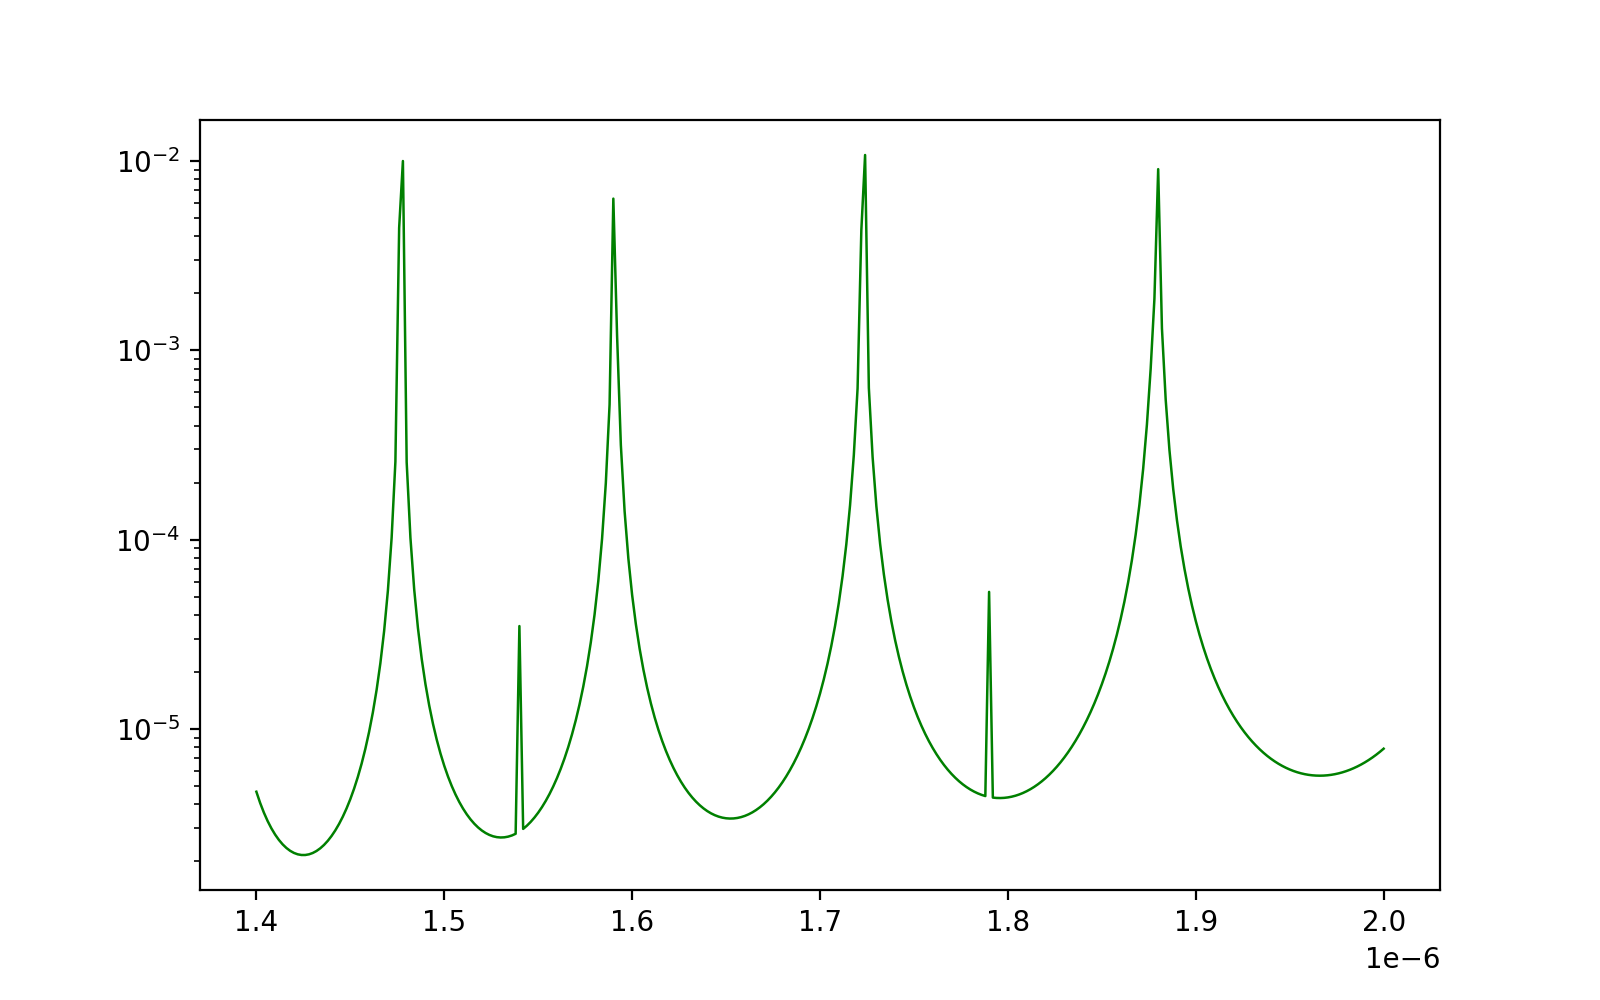

TypeError: 'float' object is not callable

In [45]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(wls, -betas.imag, color='green', linewidth=.9)
plt.yscale('log')
for l in ls:
    plt.ylim(np.e(-.001), np.e(.012))
    plt.plot([l,l], [0, .012],  linewidth=1, linestyle=':')

<IPython.core.display.Javascript object>


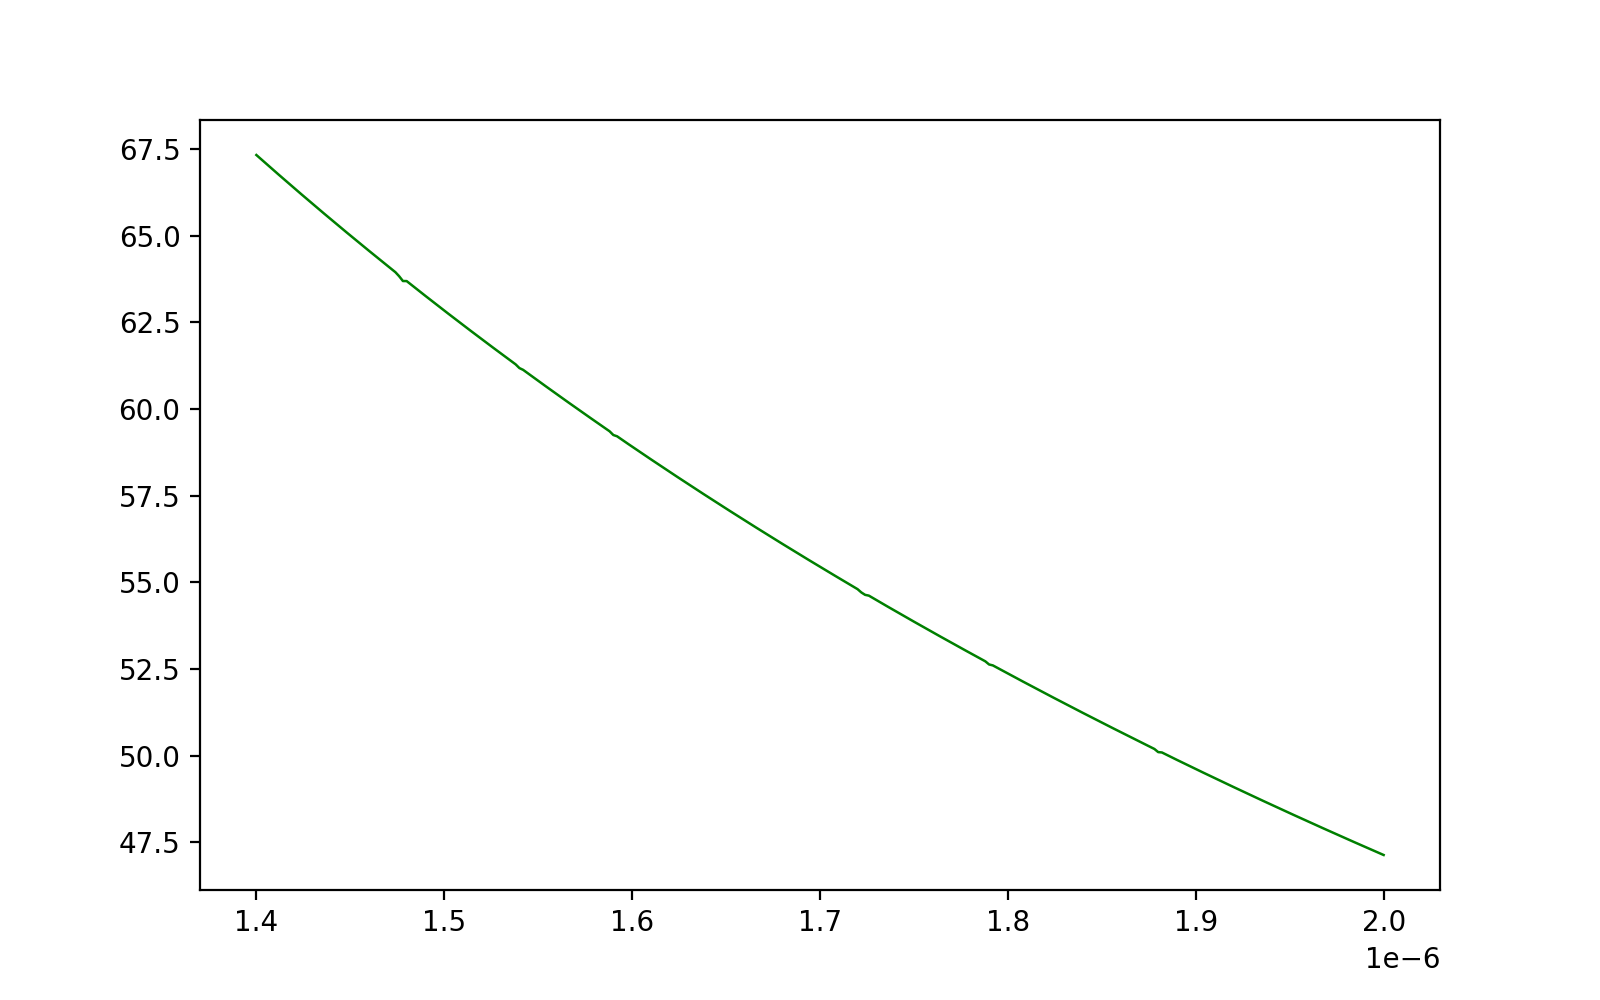

In [12]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(wls, betas.real, color='green', linewidth=.9)


In [13]:
np.save('exact_scaled_betas', betas)